# Goals: Build K nearest neighbors model from scratch and compare with sklearn model

## Unsupervised nearest neighbors

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.metrics import accuracy

Toy example

In [3]:
toy = np.array([[-3, -2], [-2, -1], [-1, -1],[1, 1], [2, 1], [3, 2]])

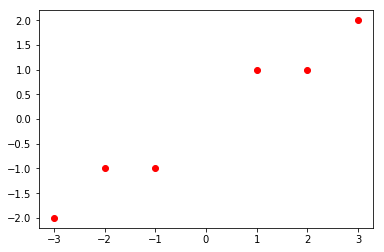

In [4]:
plt.plot(toy[:,0],toy[:,1],'ro')

## 1. Sklearn unsupervised nearest neighbors

In [6]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(toy) # 3 neighbors, including himself
dist,idx=nbrs.kneighbors(toy)
print(dist)
print(idx)

[[0.         1.41421356 2.23606798]
 [0.         1.         1.41421356]
 [0.         1.         2.23606798]
 [0.         1.         2.23606798]
 [0.         1.         1.41421356]
 [0.         1.41421356 2.23606798]]
[[0 1 2]
 [1 2 0]
 [2 1 0]
 [3 4 5]
 [4 3 5]
 [5 4 3]]


(array([[0.70710678, 0.70710678, 1.58113883]]), array([[2, 1, 0]], dtype=int64))


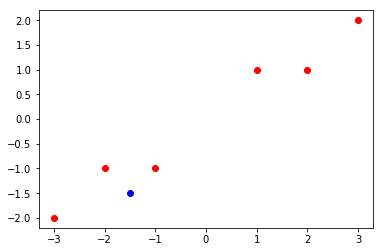

In [7]:
test = [-1.5,-1.5]
print(nbrs.kneighbors([test]))
plt.plot(toy[:,0],toy[:,1],'ro')
plt.plot(test[0],test[1],'bo')
plt.show()

## 2. My Unsupervised KNN

In [11]:
from model.knn import CustomNearestNeighbor

In [12]:
c_nn = CustomNearestNeighbor(k=3)
c_nn.fit(toy)

In [18]:
c_dist,c_idx=c_nn.kneighbors(toy)

In [16]:
c_dist == dist

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [19]:
c_idx ==idx

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

Identical results to sklearn nearest neighbors

# Supervised nearest neighbors

We will use Fashion MNIST https://github.com/zalandoresearch/fashion-mnist for benchmarking

In [20]:
# Fashion MNIST
def load_mnist(path, kind='train'):
    import os
    import struct
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        struct.unpack(">IIII", imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [21]:
labels={
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot',
}

In [22]:
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')
y_train,y_test = y_train.astype(np.int64),y_test.astype(np.int64)
print('Training set size: {}'.format(X_train.shape))
print('Testing set size: {}'.format(X_test.shape))

Training set size: (60000, 784)
Testing set size: (10000, 784)


In [23]:
#only take 5000 images for simplification
np.random.seed(42)
train_idx =np.random.permutation(5000)
test_idx = np.random.permutation(1000)
X_train = X_train[train_idx]
y_train = y_train[train_idx]
X_test = X_test[test_idx]
y_test = y_test[test_idx]

Preprocess and split dataset

In [24]:
# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

C:\Users\qtran\AppData\Local\Continuum\Miniconda3\envs\fastai-cpu\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 1. Sklearn KNeighborsClassifier

In [27]:
from sklearn.neighbors import KNeighborsClassifier

nn = KNeighborsClassifier(n_neighbors=10)
nn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [28]:
pred = nn.predict(X_test)
accuracy(y_test,pred)

0.807

## 2. My supervised KNN

In [29]:
print(X_train.shape)
print(X_test.shape)

(5000, 784)
(1000, 784)


In [32]:
c_nn = CustomNearestNeighbor(k=10)
c_nn.fit(X_train,y_train)

### uniform weights among class

In [33]:
y_pred,counter,class_sorted=c_nn.predict_classification(X_test,weighted=False)

In [34]:
accuracy_score(y_test,y_pred)

0.804

### Weight points by the inverse of distance

In [35]:
y_pred,weighted_counter,class_sorted=c_nn.predict_classification(X_test,weighted=True)

In [36]:
accuracy_score(y_test,y_pred)

0.809

Not bad! With weighted inverse-Euclidean distance, there is small boost in accuracy on test set

### Evaluate results

In [37]:
from matplotlib import pyplot as plt,cm
def evaluate(idx):
    img = X_test[idx].reshape([28,28])
    plt.imshow(img,cmap=cm.binary)
    print(f'Weights (in order): {sorted(weighted_counter[idx],reverse=True)}')
    print(f'Predictions (in order): {[labels[i] for i in class_sorted[idx]]}')
    print('Actual: ' + labels[y_test[0]])


Weights (in order): [0.3040748811530332, 0.28658216317523766, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Predictions (in order): ['Coat', 'Shirt', 'Ankle boot', 'Bag', 'Sneaker', 'Sandal', 'Dress', 'Pullover', 'Trouser', 'T-shirt/top']
Actual: Coat


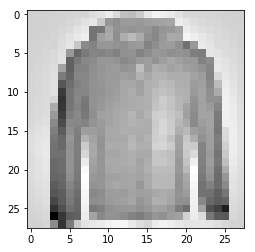

In [38]:
# Correct prediction
evaluate(0)

Based on weighted_counter, my KNN classifier results in a close weight between class 4 (Coat) with weight .304 and 6 (Shirt) with weight .286.

Weights (in order): [0.3754328103184546, 0.14807884211858424, 0.07343824003610218, 0.07208342067277425, 0.0704589146423518, 0.0, 0.0, 0.0, 0.0, 0.0]
Predictions (in order): ['T-shirt/top', 'Coat', 'Pullover', 'Dress', 'Shirt', 'Ankle boot', 'Bag', 'Sneaker', 'Sandal', 'Trouser']
Actual: Coat


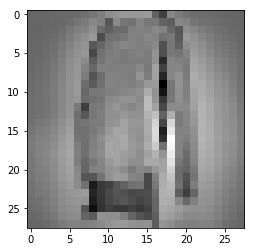

In [39]:
# Incorrect prediction
evaluate(6)